In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
model_save_dir = "/kaggle/working/"
os.makedirs(model_save_dir, exist_ok=True)

In [3]:
# Data augmentation and normalization
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Use ImageFolder to load datasets from the directories
train_dataset = ImageFolder('/kaggle/input/sign-language/IMAGE/IMAGE/train', transform=train_transforms)
val_dataset = ImageFolder('/kaggle/input/sign-language/IMAGE/IMAGE/val', transform=val_transforms)
test_dataset = ImageFolder('/kaggle/input/sign-language/IMAGE/IMAGE/test', transform=val_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 197MB/s]


In [6]:
# Modify the classifier for your specific task (36 classes for A-Z, 1-9 excluding J, Z)
vgg16.classifier[6] = nn.Linear(4096, 35)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

In [ ]:
# Variables to track the best model and save per epoch
best_val_acc = 0.0

# Training loop
num_epochs = 50
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    print(f'\nEpoch {epoch+1}/{num_epochs}')
    # Training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation step
    vgg16.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

    # Save the model for this epoch
    torch.save(vgg16.state_dict(), os.path.join(model_save_dir, f'vgg16_epoch.pth'))

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(vgg16.state_dict(), os.path.join(model_save_dir, 'vgg16_best_model.pth'))

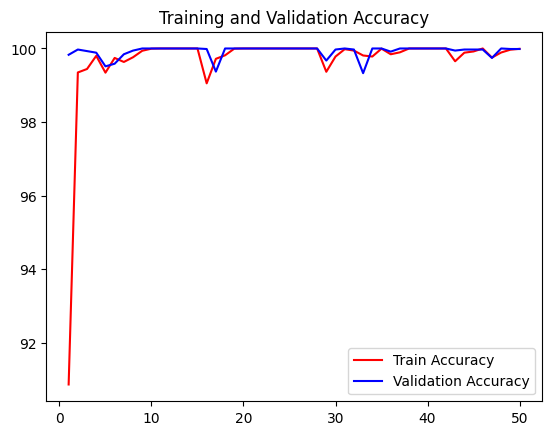

In [10]:
# Plotting training & validation accuracy and loss
epochs = range(1, num_epochs+1)
plt.figure()
plt.plot(epochs, train_acc_history, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


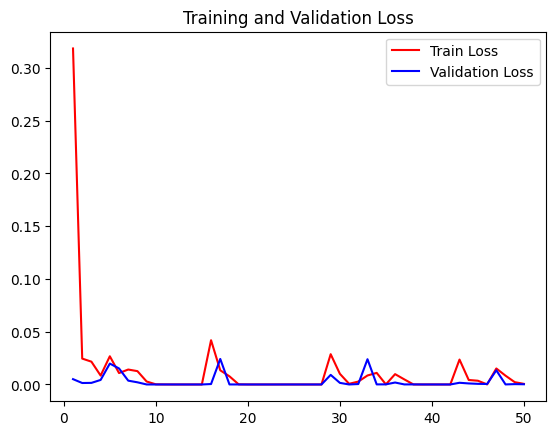

In [11]:
plt.figure()
plt.plot(epochs, train_loss_history, 'r', label='Train Loss')
plt.plot(epochs, val_loss_history, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()